In [54]:
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import Planck15 as cosmo
import sys
import astropy.io.fits as fits
from galaxy_cluster_matching import *

In [65]:
# Loading the data

galaxy_catalog_raw = fits.open('/home/farnoosh/Nextcloud/Master_Thesis_all/codes/data/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data  # galaxies
# galaxy_catalog_raw = fits.open('/home/farnoosh/Desktop/merge_gkvScience_StellarMass_allObjectsfromBoth')[1].data  # galaxies
efeds_raw = fits.open('/home/farnoosh/Nextcloud/Master_Thesis_all/codes/data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data  # clusters


# Masks
# todo: check for the magnitude and other masks to see if the groups that i have is fine
cluster_mask = (
        ~np.isnan(efeds_raw['VDISP']) &  # mask clusters which don't have VDISP values
        (efeds_raw['RA'] > 128.5007) &
        (efeds_raw['RA'] < 141.5) &
        (efeds_raw['DEC'] > -2.05) &
        (efeds_raw['DEC'] < 3.02)
)

galaxy_mask = (
        (galaxy_catalog_raw['uberclass'] == 1) &  # classified as galaxy
        # (galaxy_catalog_raw['duplicate'] == False) &
        # (galaxy_catalog_raw['mask'] == False) &
        # (galaxy_catalog_raw['NQ'] > 2) & #confidently measured redshift
        # (galaxy_catalog_raw['SC'] > 3) &
        (galaxy_catalog_raw['mstar'] > 0) &
        # (galaxy_catalog_raw['starmask'] == False) &
        (galaxy_catalog_raw['Z'] < 0.7) &
        (galaxy_catalog_raw['RAcen'] > 128.4) &
        (galaxy_catalog_raw['RAcen'] < 145.0) &
        (galaxy_catalog_raw['Deccen'] > -2.6) &
        (galaxy_catalog_raw['Deccen'] < 5.7)
)

galaxy_catalog = galaxy_catalog_raw[galaxy_mask]
efeds_catalog = efeds_raw[cluster_mask]
print('number of the galaxies after masking: ', len(galaxy_catalog))
print('number of the clusters after masking: ', len(efeds_catalog))


number of the galaxies after masking:  81015
number of the clusters after masking:  162


In [66]:
# Dataframes
cluster_df = pd.DataFrame({
    'c_ID': efeds_catalog['ID-SRC'].byteswap().newbyteorder(),
    'c_NAME': efeds_catalog['NAME'].byteswap().newbyteorder(),
    'RA': efeds_catalog['RA'].byteswap().newbyteorder(),
    'DEC': efeds_catalog['DEC'].byteswap().newbyteorder(),
    'z': efeds_catalog['ZBEST'].byteswap().newbyteorder(),
    'cluster_radius_Mpc': efeds_catalog['R_LAMBDA'].byteswap().newbyteorder(),
    'cluster_Velocity_Dispersion': efeds_catalog['VDISP'].byteswap().newbyteorder(),
    'VDISP_error': efeds_catalog['VDISP_ERR'].byteswap().newbyteorder()
})


galaxy_df = pd.DataFrame({
    'g_ID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
    'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
    'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
    'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
    'g_mass': galaxy_catalog['mstar'].byteswap().newbyteorder()
})


In [67]:
print(galaxy_df['g_mass'])

0        3.294812e+10
1        1.506049e+10
2        5.989433e+10
3        9.169161e+10
4        2.737705e+11
             ...     
81010    1.637729e+10
81011    9.149594e+07
81012    1.054762e+08
81013    6.388143e+10
81014    7.109373e+07
Name: g_mass, Length: 81015, dtype: float32


In [44]:
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)

Progress: 99.99876616326128%%%%%

In [45]:
print(matched_galaxy_dataframe[matched_galaxy_dataframe['environment'] != 'Field'])


                  g_ID          RA       DEC        z    environment  \
8      130990151906125  131.440319 -0.506608  0.15497  ClusterMember   
34     136991156106976  136.494642 -0.426489  0.29648  ClusterMember   
38     130990152406286  131.439805 -0.491412  0.15598  ClusterMember   
89     138000000504221  138.582437  0.314078  0.16170  ClusterMember   
172    138000004003987  138.579536  0.292041  0.16673  ClusterMember   
...                ...         ...       ...      ...            ...   
80944  133990077304335  134.510628 -0.675104  0.24491  ClusterMember   
80956  130990148605975  131.443428 -0.520688  0.15834  ClusterMember   
80959  136991151506756  136.499098 -0.447140  0.30138  ClusterMember   
80988  130990149606322  131.442491 -0.487985  0.15737  ClusterMember   
81006  140000361008749  140.243485  0.740552  0.15858  ClusterMember   

      cluster_mass           cluster_name  
8             None  eFEDSJ084544.3-002914  
34            None  eFEDSJ090600.3-002521  
38 

In [46]:

# Find the clusters that have galaxies among them
unique_cluster_ids = matched_galaxy_dataframe['cluster_name'].unique()

# Print the clusters and their galaxies
cluster_galaxies = matched_galaxy_dataframe.groupby('cluster_name')['g_ID'].apply(list).reset_index()
cluster_galaxies['num_galaxies'] = cluster_galaxies['g_ID'].apply(len)

# Print the clusters with galaxies
for index, row in cluster_galaxies.iterrows():
    print(f"Cluster {row['cluster_name']} has the following {len(row['g_ID'])} galaxies within: {row['g_ID']}")

Cluster eFEDSJ083503.2+010756 has the following 2 galaxies within: [129010867102283, 129010892102535]
Cluster eFEDSJ083651.3+030002 has the following 2 galaxies within: [129020867111101, 129020874611193]
Cluster eFEDSJ083654.6+025954 has the following 20 galaxies within: [129020754611149, 129020765311309, 129020772711257, 129020773010920, 129020778211401, 129020789011021, 129020798811315, 129020805311478, 129020809511497, 129020813311435, 129020814211457, 129020818011458, 129020818111167, 129020818710946, 129020830411303, 129020830411211, 129020837511203, 129020843911386, 129020864311407, 129020816311509]
Cluster eFEDSJ083723.6+012413 has the following 3 galaxies within: [129010249405188, 129010251405245, 129010256904912]
Cluster eFEDSJ083802.9+015626 has the following 2 galaxies within: [129020496200495, 129010071711115]
Cluster eFEDSJ083807.6+002501 has the following 15 galaxies within: [129000018705546, 129000030605704, 129000034306108, 129000062305810, 130001047205365, 130001073105

In [47]:
# Find the maximum number of galaxies in a cluster
max_galaxies_row = cluster_galaxies.loc[cluster_galaxies['num_galaxies'].idxmax()]
print(f"Cluster {max_galaxies_row['cluster_name']} has the maximum number of galaxies: {max_galaxies_row['num_galaxies']}")

# Count the number of clusters with only one galaxy within them
clusters_with_one_galaxy = sum(cluster_galaxies['num_galaxies'] == 1)
print(f"Number of clusters with only one galaxy: {clusters_with_one_galaxy}")

Cluster eFEDSJ085027.8+001503 has the maximum number of galaxies: 68
Number of clusters with only one galaxy: 12


In [48]:
# Calculate the total number of galaxies within clusters
total_galaxies = cluster_galaxies['num_galaxies'].sum()
print(f"Total number of galaxies within clusters: {total_galaxies}")

Total number of galaxies within clusters: 1473


In [49]:
# Find clusters with no galaxies
all_cluster_names = cluster_df['c_NAME'].unique()
clusters_with_galaxies = matched_galaxy_dataframe['cluster_name'].dropna().unique()
clusters_without_galaxies = np.setdiff1d(all_cluster_names, clusters_with_galaxies)


print("Clusters with no galaxies within:", len(clusters_without_galaxies))
for cluster_name in clusters_without_galaxies:
    print(f"Cluster name: {cluster_name}")

Clusters with no galaxies within: 44
Cluster name: eFEDSJ083759.5-003643
Cluster name: eFEDSJ083806.9-003600
Cluster name: eFEDSJ083903.5-011454
Cluster name: eFEDSJ084006.1+025913
Cluster name: eFEDSJ084021.6+020132
Cluster name: eFEDSJ084051.7+014122
Cluster name: eFEDSJ084135.0+010150
Cluster name: eFEDSJ084151.7+004351
Cluster name: eFEDSJ084324.2-001438
Cluster name: eFEDSJ084454.0+010021
Cluster name: eFEDSJ084459.2-011902
Cluster name: eFEDSJ084545.2+005535
Cluster name: eFEDSJ084833.2-012216
Cluster name: eFEDSJ084905.3+021435
Cluster name: eFEDSJ085121.2+012856
Cluster name: eFEDSJ085130.0-004609
Cluster name: eFEDSJ085419.5-000925
Cluster name: eFEDSJ085438.5+001211
Cluster name: eFEDSJ085517.2+013508
Cluster name: eFEDSJ085541.2+002740
Cluster name: eFEDSJ085623.6-013612
Cluster name: eFEDSJ085626.2+021348
Cluster name: eFEDSJ085950.1-001221
Cluster name: eFEDSJ090010.4+023631
Cluster name: eFEDSJ090053.0-002837
Cluster name: eFEDSJ090133.2+021651
Cluster name: eFEDSJ090133.

Best-fit parameters: [ 1.0e-02  1.0e+11 -1.3e+00]


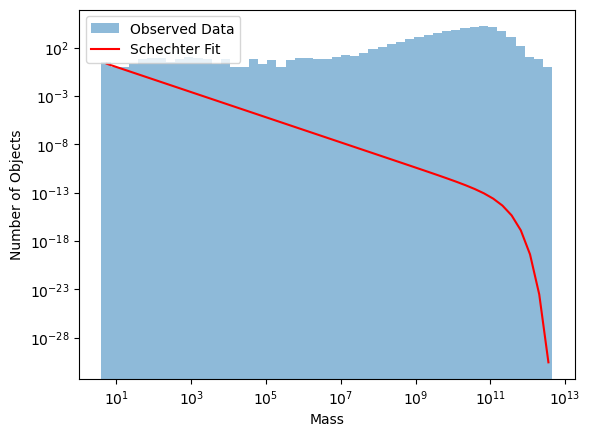

In [68]:
# Function to fit a Schechter function to the mass data
def schechter(M, phi_star, M_star, alpha):
    return (phi_star / M_star) * (M / M_star)**alpha * np.exp(-M / M_star)

# Bin the observed masses to create a histogram
bins = np.logspace(np.log10(min(galaxy_df['g_mass'])), np.log10(max(galaxy_df['g_mass'])), 50)
hist, bin_edges = np.histogram(galaxy_df['g_mass'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guesses for the parameters
initial_guesses = [0.01, 1e11, -1.3]

# Fit the Schechter function to the data
popt, pcov = curve_fit(schechter, bin_centers, hist, p0=initial_guesses)

# Print the best-fit parameters
print("Best-fit parameters:", popt)

# Plot the data and the fitted function
plt.figure()
plt.hist(galaxy_df['g_mass'], bins=bins, alpha=0.5, label='Observed Data')
plt.plot(bin_centers, schechter(bin_centers, *popt), label='Schechter Fit', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass')
plt.ylabel('Number of Objects')
plt.legend()
plt.show()
